In [3]:
import pandas as pd

# Part 1: Define Your Excel Filename
# IMPORTANT: Change this to the exact name of your Excel file.
excel_filename = 'LXS-Monolithe-21.xlsx'

try:
    # Use pd.ExcelFile to read the file metadata
    xls = pd.ExcelFile(excel_filename)

    # The .sheet_names attribute holds a list of all sheets in the file
    sheet_names = xls.sheet_names

    print("Sheets found in the Excel file:")
    # Loop through and print each sheet name
    for name in sheet_names:
        print(f"- {name}")

except FileNotFoundError:
    print(f"\nERROR: The file '{excel_filename}' was not found.")
    print("Please make sure the filename is correct and it's uploaded to your Colab session.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

Sheets found in the Excel file:
- Monolithic-Al 
- Monolithic-As
- Monolithic-Ba
- Monolithic-Br
- Monolithic-Ca
- Monolithic-Cd
- Monolithic-Cl
- Monolithic-Cr
- Monolithic-Cu
- Monolithic-F
- Monolithic-Fe
- Monolithic-K
- Monolithic-Mg
- Monolithic-Mo
- Monolithic-Na
- Monolithic-P
- Monolithic-Pb
- Monolithic-Si
- Monolithic-SO4
- Monolithic-Zn
- Material Attributes
- Index


In [22]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def extract_leaching_data_from_sheet(sheet_df, material_name):
    """
    Extract leaching data from a single material sheet
    Handles both standard format and special Bromide format correctly
    """
    consolidated_data = []
    current_material_condition = None

    for idx, row in sheet_df.iterrows():
        row_values = [str(cell) if pd.notna(cell) else '' for cell in row]
        row_text = ' '.join(row_values)

        # Check if this is a material condition header
        if any(keyword in row_text for keyword in ['Cement concrete', 'Cement mortar', 'Mortar', 'Sewage sludge']):
            for cell in row_values:
                if len(cell) > 20 and any(keyword in cell for keyword in ['Cement', 'Mortar', 'Sewage']):
                    current_material_condition = cell
                    break

        # Check if this is a data header row (contains pH and Cumulative release)
        if 'pH' in row_text and 'Cumulative release' in row_text:
            # Determine column structure based on whether "Time" is present
            has_time_column = 'Time' in row_text

            # Look for data in subsequent rows
            data_idx = idx + 1

            while data_idx < len(sheet_df):
                data_row = sheet_df.iloc[data_idx]

                # Stop if we hit another header or empty section
                if len(data_row) < 5 or (pd.isna(data_row.iloc[2]) and pd.isna(data_row.iloc[3])):
                    break

                try:
                    if has_time_column:
                        # Standard format: pH, Time, Cumulative Release in columns 2, 3, 4
                        ph_val = pd.to_numeric(data_row.iloc[2], errors='coerce')
                        time_val = pd.to_numeric(data_row.iloc[3], errors='coerce')
                        cumulative_release = pd.to_numeric(data_row.iloc[4], errors='coerce')
                    else:
                        # Special Bromide format: Fraction, pH, Cumulative Release in columns 2, 3, 4
                        fraction_val = pd.to_numeric(data_row.iloc[2], errors='coerce')
                        ph_val = pd.to_numeric(data_row.iloc[3], errors='coerce')
                        cumulative_release = pd.to_numeric(data_row.iloc[4], errors='coerce')

                        # Map fraction to time values (based on standard leaching test time points)
                        time_mapping = {1: 0.08, 2: 1, 3: 2.25, 4: 4, 5: 9, 6: 16, 7: 28, 8: 36, 9: 64}
                        time_val = time_mapping.get(fraction_val, np.nan)

                    if pd.notna(ph_val) and pd.notna(cumulative_release) and pd.notna(time_val):
                        consolidated_data.append({
                            'Material': material_name,
                            'Material_Condition': current_material_condition,
                            'pH': ph_val,
                            'Time_days': time_val,
                            'Cumulative_Release_mg_m2': cumulative_release
                        })
                except:
                    pass

                data_idx += 1

    return consolidated_data

def clean_material_condition(condition_str):
    """Clean and extract features from material condition strings"""
    if pd.isna(condition_str):
        return 'Unknown', 'Unknown', 'Unknown'

    condition_str = str(condition_str).strip()

    # Extract cement type
    cement_type = 'Unknown'
    if 'CEM I' in condition_str and 'CEM II' not in condition_str:
        cement_type = 'CEM_I'
    elif 'CEM II' in condition_str and 'CEM III' not in condition_str:
        cement_type = 'CEM_II'
    elif 'CEM III' in condition_str:
        cement_type = 'CEM_III'
    elif 'CEM V' in condition_str:
        cement_type = 'CEM_V'

    # Extract form type
    form_type = 'Unknown'
    if 'Cement concrete' in condition_str:
        form_type = 'Concrete'
    elif 'Cement mortar' in condition_str or 'Mortar' in condition_str:
        form_type = 'Mortar'
    elif 'Sewage sludge' in condition_str:
        form_type = 'Sewage_Sludge'

    # Extract statistical measure
    stat_measure = 'Unknown'
    if 'Monolith-[CL-]' in condition_str:
        stat_measure = 'CL_Minus'
    elif 'Monolith-[CL+]' in condition_str or 'Monolith-CL' in condition_str:
        stat_measure = 'CL_Plus'
    elif 'Monolith-[LPx]' in condition_str:
        stat_measure = 'LPx'
    elif 'Monolith-[Med]' in condition_str:
        stat_measure = 'Med'
    elif 'Monolith-[UPx]' in condition_str:
        stat_measure = 'UPx'
    elif 'Monolith-[X]' in condition_str:
        stat_measure = 'X'

    return cement_type, form_type, stat_measure

# STEP 1: LOAD AND CONSOLIDATE DATA
print("Step 1: Loading and consolidating data from Excel file...")

# Load Excel file (make sure to upload it to Colab first)
file_path = "LXS-Monolithe-21.xlsx"  # Update this path
df = pd.read_excel(file_path, sheet_name=None)

# Get material sheet names
material_sheets = [name for name in df.keys() if 'Monolithic-' in name]
print(f"Found {len(material_sheets)} material sheets")

# Consolidate all data
all_data = []
for sheet_name in material_sheets:
    material_name = sheet_name.replace('Monolithic-', '').strip()
    sheet_data = extract_leaching_data_from_sheet(df[sheet_name], material_name)
    all_data.extend(sheet_data)
    print(f"  {material_name}: {len(sheet_data)} data points")

# Create consolidated DataFrame
consolidated_df = pd.DataFrame(all_data)
print(f"\nTotal consolidated data points: {len(consolidated_df)}")

# STEP 2: FEATURE ENGINEERING
print("\nStep 2: Feature engineering...")

# Extract features from material conditions
material_features = consolidated_df['Material_Condition'].apply(clean_material_condition)
consolidated_df['Cement_Type'] = [x[0] for x in material_features]
consolidated_df['Form_Type'] = [x[1] for x in material_features]
consolidated_df['Stat_Measure'] = [x[2] for x in material_features]

# Encode categorical variables
label_encoders = {}
categorical_columns = ['Material', 'Cement_Type', 'Form_Type', 'Stat_Measure']

for col in categorical_columns:
    le = LabelEncoder()
    consolidated_df[f'{col}_encoded'] = le.fit_transform(consolidated_df[col])
    label_encoders[col] = le
    print(f"  {col}: {consolidated_df[col].nunique()} categories")

# Create additional engineered features
consolidated_df['log_Time'] = np.log1p(consolidated_df['Time_days'])
consolidated_df['pH_squared'] = consolidated_df['pH'] ** 2
consolidated_df['Time_pH_interaction'] = consolidated_df['Time_days'] * consolidated_df['pH']

# Final feature set for ML
feature_columns = [
    'Material_encoded', 'Cement_Type_encoded', 'Form_Type_encoded',
    'Stat_Measure_encoded', 'pH', 'Time_days', 'log_Time',
    'pH_squared', 'Time_pH_interaction'
]

X = consolidated_df[feature_columns]
y = consolidated_df['Cumulative_Release_mg_m2']

# STEP 3: PREPARE FOR ML
print("\nStep 3: Preparing data for machine learning...")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=consolidated_df['Material']
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Save consolidated data
consolidated_df.to_csv('consolidated_leaching_data_FINAL.csv', index=False)
print("\n✓ Data saved to 'consolidated_leaching_data_FINAL.csv'")

# Display summary statistics
print("\nData Summary:")
print(f"Materials: {sorted(consolidated_df['Material'].unique())}")
print(f"Number of materials: {consolidated_df['Material'].nunique()}")
print(f"pH range: {consolidated_df['pH'].min():.2f} - {consolidated_df['pH'].max():.2f}")
print(f"Time range: {consolidated_df['Time_days'].min():.2f} - {consolidated_df['Time_days'].max():.2f}")
print(f"Leaching range: {consolidated_df['Cumulative_Release_mg_m2'].min():.2f} - {consolidated_df['Cumulative_Release_mg_m2'].max():.2f}")

# Show data distribution by material
print("\nData Distribution by Material:")
material_counts = consolidated_df['Material'].value_counts().sort_index()
for material, count in material_counts.items():
    print(f"  {material}: {count} data points")

print("\n" + "="*60)
print("DATA CONSOLIDATION COMPLETE!")
print("="*60)
print("\nNext steps:")
print("1. Use X_train, y_train for training ML models")
print("2. Use X_test, y_test for evaluation")
print("3. Use label_encoders dictionary to encode new user inputs")
print("4. Available features:", feature_columns)
print("\nKey fixes applied:")
print("- Aluminum: Correct column indexing (2,3,4 for pH,Time,Release)")
print("- Bromide: Special handling for missing Time column")
print("- All other materials: Standard extraction maintained")


Step 1: Loading and consolidating data from Excel file...
Found 20 material sheets
  Al: 225 data points
  As: 225 data points
  Ba: 225 data points
  Br: 54 data points
  Ca: 97 data points
  Cd: 225 data points
  Cl: 110 data points
  Cr: 225 data points
  Cu: 225 data points
  F: 54 data points
  Fe: 97 data points
  K: 225 data points
  Mg: 97 data points
  Mo: 225 data points
  Na: 225 data points
  P: 97 data points
  Pb: 225 data points
  Si: 97 data points
  SO4: 190 data points
  Zn: 225 data points

Total consolidated data points: 3368

Step 2: Feature engineering...
  Material: 20 categories
  Cement_Type: 5 categories
  Form_Type: 3 categories
  Stat_Measure: 7 categories

Step 3: Preparing data for machine learning...
Training set: 2694 samples
Test set: 674 samples

✓ Data saved to 'consolidated_leaching_data_FINAL.csv'

Data Summary:
Materials: ['Al', 'As', 'Ba', 'Br', 'Ca', 'Cd', 'Cl', 'Cr', 'Cu', 'F', 'Fe', 'K', 'Mg', 'Mo', 'Na', 'P', 'Pb', 'SO4', 'Si', 'Zn']
Number of

In [24]:
# Step 2: Complete ML Pipeline Development
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')

print("📊 Feature Engineering & Data Preparation:")

# Enhanced Feature Engineering
def clean_material_condition(condition_str):
    if pd.isna(condition_str):
        return 'Unknown', 'Unknown', 'Unknown'

    condition_str = str(condition_str).strip()

    # Extract cement type
    cement_type = 'Unknown'
    if 'CEM I' in condition_str and 'CEM II' not in condition_str:
        cement_type = 'CEM_I'
    elif 'CEM II' in condition_str and 'CEM III' not in condition_str:
        cement_type = 'CEM_II'
    elif 'CEM III' in condition_str:
        cement_type = 'CEM_III'
    elif 'CEM V' in condition_str:
        cement_type = 'CEM_V'

    # Extract form type
    form_type = 'Unknown'
    if 'Cement concrete' in condition_str:
        form_type = 'Concrete'
    elif 'Cement mortar' in condition_str or 'Mortar' in condition_str:
        form_type = 'Mortar'
    elif 'Sewage sludge' in condition_str:
        form_type = 'Sewage_Sludge'

    # Extract statistical measure
    stat_measure = 'Unknown'
    if 'Monolith-[CL-]' in condition_str:
        stat_measure = 'CL_Minus'
    elif 'Monolith-[CL+]' in condition_str:
        stat_measure = 'CL_Plus'
    elif 'Monolith-[LPx]' in condition_str:
        stat_measure = 'LPx'
    elif 'Monolith-[Med]' in condition_str:
        stat_measure = 'Med'
    elif 'Monolith-[UPx]' in condition_str:
        stat_measure = 'UPx'
    elif 'Monolith-[X]' in condition_str:
        stat_measure = 'X'

    return cement_type, form_type, stat_measure

# Apply feature extraction
material_features = df['Material_Condition'].apply(clean_material_condition)
df['Cement_Type'] = [x[0] for x in material_features]
df['Form_Type'] = [x[1] for x in material_features]
df['Stat_Measure'] = [x[2] for x in material_features]

# Encode categorical variables
label_encoders = {}
categorical_columns = ['Material', 'Cement_Type', 'Form_Type', 'Stat_Measure']

for col in categorical_columns:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"  {col}: {df[col].nunique()} categories")

# Create engineered features
print(f"\n🔧 Creating Advanced Features:")
df['log_Time'] = np.log1p(df['Time_days'])
df['pH_squared'] = df['pH'] ** 2
df['Time_pH_interaction'] = df['Time_days'] * df['pH']
df['pH_normalized'] = (df['pH'] - df['pH'].mean()) / df['pH'].std()
df['sqrt_Time'] = np.sqrt(df['Time_days'])
df['inv_pH'] = 1 / (df['pH'] + 0.1)  # Avoid division by zero

# Target transformation for better distribution
df['log_Release'] = np.log1p(df['Cumulative_Release_mg_m2'])

print(f"  ✓ Log transformations")
print(f"  ✓ Polynomial features (pH², √Time)")
print(f"  ✓ Interaction features (Time × pH)")
print(f"  ✓ Normalized features")

# Define comprehensive feature sets
feature_columns = [
    'Material_encoded', 'Cement_Type_encoded', 'Form_Type_encoded',
    'Stat_Measure_encoded', 'pH', 'Time_days', 'log_Time',
    'pH_squared', 'Time_pH_interaction', 'pH_normalized', 'sqrt_Time', 'inv_pH'
]

# Prepare data
X = df[feature_columns]
y_original = df['Cumulative_Release_mg_m2']
y_log = df['log_Release']

print(f"\n📈 Dataset Overview:")
print(f"Features: {len(feature_columns)}")
print(f"Samples: {len(df)}")
print(f"Target distribution (original): {y_original.describe()}")

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42, stratify=df['Material']
)

# Also keep original scale targets for final evaluation
_, _, y_train_orig, y_test_orig = train_test_split(
    X, y_original, test_size=0.2, random_state=42, stratify=df['Material']
)

print(f"\n📊 Data Split:")
print(f"Training: {X_train.shape[0]} samples")
print(f"Testing: {X_test.shape[0]} samples")

# Scale features for algorithms that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Data preprocessing complete!")

📊 Feature Engineering & Data Preparation:
  Material: 20 categories
  Cement_Type: 5 categories
  Form_Type: 3 categories
  Stat_Measure: 7 categories

🔧 Creating Advanced Features:
  ✓ Log transformations
  ✓ Polynomial features (pH², √Time)
  ✓ Interaction features (Time × pH)
  ✓ Normalized features

📈 Dataset Overview:
Features: 12
Samples: 3368
Target distribution (original): count    3368.000000
mean       24.447112
std        63.919421
min         0.080000
25%         1.000000
50%         4.000000
75%        28.000000
max      1443.505863
Name: Cumulative_Release_mg_m2, dtype: float64

📊 Data Split:
Training: 2694 samples
Testing: 674 samples

✅ Data preprocessing complete!


In [25]:
# INSTALLATION AND SETUP CODE - RUN THIS FIRST IN COLAB
# Run each section separately and verify results

# ===== SECTION 1: INSTALL REQUIRED PACKAGES =====
print("📦 Installing required packages...")
!pip install xgboost lightgbm optuna scikit-optimize -q

# ===== SECTION 2: IMPORT AND SETUP =====
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Core ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb

print("✅ All packages imported successfully!")

# ===== SECTION 3: DATA LOADING FUNCTION =====
def load_and_consolidate_data(file_path):
    """Load and consolidate data from Excel file"""

    def extract_leaching_data_from_sheet(sheet_df, material_name):
        consolidated_data = []
        current_material_condition = None

        for idx, row in sheet_df.iterrows():
            row_values = [str(cell) if pd.notna(cell) else '' for cell in row]
            row_text = ' '.join(row_values)

            if any(keyword in row_text for keyword in ['Cement concrete', 'Cement mortar', 'Mortar', 'Sewage sludge']):
                for cell in row_values:
                    if len(cell) > 15 and any(keyword in cell for keyword in ['Cement', 'Mortar', 'Sewage']):
                        current_material_condition = cell
                        break

            if 'pH' in row_text and 'Cumulative release' in row_text:
                has_time_column = 'Time' in row_text
                data_idx = idx + 1

                while data_idx < len(sheet_df):
                    data_row = sheet_df.iloc[data_idx]

                    if len(data_row) < 5 or (pd.isna(data_row.iloc[2]) and pd.isna(data_row.iloc[3])):
                        break

                    try:
                        if has_time_column:
                            ph_val = pd.to_numeric(data_row.iloc[2], errors='coerce')
                            time_val = pd.to_numeric(data_row.iloc[3], errors='coerce')
                            cumulative_release = pd.to_numeric(data_row.iloc[4], errors='coerce')
                        else:
                            fraction_val = pd.to_numeric(data_row.iloc[2], errors='coerce')
                            ph_val = pd.to_numeric(data_row.iloc[3], errors='coerce')
                            cumulative_release = pd.to_numeric(data_row.iloc[4], errors='coerce')
                            time_mapping = {1: 0.08, 2: 1, 3: 2.25, 4: 4, 5: 9, 6: 16, 7: 28, 8: 36, 9: 64}
                            time_val = time_mapping.get(fraction_val, np.nan)

                        if all(pd.notna([ph_val, time_val, cumulative_release])):
                            consolidated_data.append({
                                'Material': material_name,
                                'Material_Condition': current_material_condition,
                                'pH': ph_val,
                                'Time_days': time_val,
                                'Cumulative_Release_mg_m2': cumulative_release
                            })
                    except:
                        pass

                    data_idx += 1

        return consolidated_data

    # Load Excel file
    print(f"📊 Loading data from {file_path}...")
    df_sheets = pd.read_excel(file_path, sheet_name=None)

    # Get material sheets
    material_sheets = [name for name in df_sheets.keys() if 'Monolithic-' in name]
    all_data = []

    for sheet_name in material_sheets:
        material_name = sheet_name.replace('Monolithic-', '').strip()
        sheet_data = extract_leaching_data_from_sheet(df_sheets[sheet_name], material_name)
        all_data.extend(sheet_data)
        print(f"  {material_name}: {len(sheet_data)} data points")

    df = pd.DataFrame(all_data)
    print(f"\n✅ Consolidated {len(df)} total data points from {df['Material'].nunique()} materials")

    return df

# ===== SECTION 4: ADVANCED FEATURE ENGINEERING =====
def create_advanced_features(df):
    """Create comprehensive feature set for better model performance"""

    print("🔧 Creating advanced features...")

    # Material condition features
    def extract_material_features(condition_str):
        if pd.isna(condition_str):
            return 'Unknown', 'Unknown', 'Unknown', 0, 0

        condition_str = str(condition_str).strip()

        # Cement type
        cement_type = 'Unknown'
        cement_content = 0
        if 'CEM I' in condition_str and 'CEM II' not in condition_str:
            cement_type = 'CEM_I'
            cement_content = 100
        elif 'CEM II/A' in condition_str:
            cement_type = 'CEM_II_A'
            cement_content = 80
        elif 'CEM II/B' in condition_str:
            cement_type = 'CEM_II_B'
            cement_content = 65
        elif 'CEM III' in condition_str:
            cement_type = 'CEM_III'
            cement_content = 50
        elif 'CEM V' in condition_str:
            cement_type = 'CEM_V'
            cement_content = 60

        # Form type
        form_type = 'Unknown'
        if 'Cement concrete' in condition_str:
            form_type = 'Concrete'
        elif 'mortar' in condition_str.lower():
            form_type = 'Mortar'
        elif 'Sewage sludge' in condition_str:
            form_type = 'Sewage_Sludge'

        # Statistical measure
        stat_measure = 'Unknown'
        if 'CL-' in condition_str:
            stat_measure = 'CL_Minus'
        elif 'CL+' in condition_str:
            stat_measure = 'CL_Plus'
        elif 'LPx' in condition_str:
            stat_measure = 'LPx'
        elif 'Med' in condition_str:
            stat_measure = 'Med'
        elif 'UPx' in condition_str:
            stat_measure = 'UPx'

        # Additives count
        additives_count = len([x for x in ['GBFS', 'FA', 'LS', 'SF'] if x in condition_str])

        return cement_type, form_type, stat_measure, cement_content, additives_count

    # Apply feature extraction
    material_features = df['Material_Condition'].apply(extract_material_features)
    df['Cement_Type'] = [x[0] for x in material_features]
    df['Form_Type'] = [x[1] for x in material_features]
    df['Stat_Measure'] = [x[2] for x in material_features]
    df['Cement_Content'] = [x[3] for x in material_features]
    df['Additives_Count'] = [x[4] for x in material_features]

    # Encode categorical variables
    label_encoders = {}
    categorical_columns = ['Material', 'Cement_Type', 'Form_Type', 'Stat_Measure']

    for col in categorical_columns:
        le = LabelEncoder()
        df[f'{col}_encoded'] = le.fit_transform(df[col])
        label_encoders[col] = le
        print(f"  {col}: {df[col].nunique()} categories")

    # Mathematical transformations
    print("  Creating mathematical transformations...")
    df['log_Time'] = np.log1p(df['Time_days'])
    df['log_pH'] = np.log(df['pH'])
    df['sqrt_Time'] = np.sqrt(df['Time_days'])
    df['sqrt_pH'] = np.sqrt(df['pH'])
    df['pH_squared'] = df['pH'] ** 2
    df['pH_cubed'] = df['pH'] ** 3
    df['Time_squared'] = df['Time_days'] ** 2

    # Interaction features
    print("  Creating interaction features...")
    df['Time_pH_interaction'] = df['Time_days'] * df['pH']
    df['log_Time_pH'] = df['log_Time'] * df['pH']
    df['Material_pH_interaction'] = df['Material_encoded'] * df['pH']
    df['Material_Time_interaction'] = df['Material_encoded'] * df['Time_days']

    # Normalized features
    df['pH_normalized'] = (df['pH'] - df['pH'].mean()) / df['pH'].std()
    df['Time_normalized'] = (df['Time_days'] - df['Time_days'].mean()) / df['Time_days'].std()

    # Domain knowledge features
    print("  Creating domain-specific features...")
    df['Alkalinity_index'] = df['pH'] - 7  # Distance from neutral
    df['Reactivity_score'] = df['pH'] * np.log1p(df['Time_days'])
    df['Leaching_potential'] = (df['pH'] ** 2) * np.sqrt(df['Time_days'])

    # Material grouping by chemical similarity
    material_groups = {
        'Al': 0, 'Fe': 0, 'Si': 0,  # Light metals/metalloids
        'As': 1, 'Cr': 1, 'Mo': 1,  # Toxic heavy elements
        'Ba': 2, 'P': 2,             # Alkaline earth/phosphorus
        'Br': 3, 'F': 3, 'Cl': 3,   # Halogens
        'Ca': 4, 'K': 4, 'Mg': 4, 'Na': 4,  # Alkali/alkaline earth
        'Cd': 5, 'Cu': 5, 'Pb': 5, 'Zn': 5,  # Heavy metals
        'SO4': 6                     # Sulfates
    }
    df['Material_group'] = df['Material'].map(material_groups)

    # Target transformation
    df['log_Release'] = np.log1p(df['Cumulative_Release_mg_m2'])

    # Define comprehensive feature set
    feature_columns = [
        'Material_encoded', 'Cement_Type_encoded', 'Form_Type_encoded', 'Stat_Measure_encoded',
        'pH', 'Time_days', 'Cement_Content', 'Additives_Count',
        'log_Time', 'log_pH', 'sqrt_Time', 'sqrt_pH',
        'pH_squared', 'pH_cubed', 'Time_squared',
        'Time_pH_interaction', 'log_Time_pH', 'Material_pH_interaction', 'Material_Time_interaction',
        'pH_normalized', 'Time_normalized',
        'Alkalinity_index', 'Reactivity_score', 'Leaching_potential', 'Material_group'
    ]

    print(f"✅ Created {len(feature_columns)} features")

    return df, feature_columns, label_encoders

# ===== SECTION 5: MODEL TRAINING FUNCTION =====
def train_advanced_models(X_train, X_test, y_train, y_test, y_train_orig, y_test_orig):
    """Train multiple advanced models and return best performer"""

    print("🤖 Training advanced ML models...")

    # Power transformation and scaling
    pt = PowerTransformer(method='yeo-johnson')
    X_train_transformed = pt.fit_transform(X_train)
    X_test_transformed = pt.transform(X_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_transformed)
    X_test_scaled = scaler.transform(X_test_transformed)

    # Define optimized models
    models = {
        'XGBoost': xgb.XGBRegressor(
            n_estimators=400,
            max_depth=8,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ),
        'LightGBM': lgb.LGBMRegressor(
            n_estimators=400,
            max_depth=8,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        'Random Forest': RandomForestRegressor(
            n_estimators=300,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ),
        'Extra Trees': ExtraTreesRegressor(
            n_estimators=300,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=300,
            max_depth=8,
            learning_rate=0.05,
            subsample=0.8,
            random_state=42
        ),
        'Neural Network': MLPRegressor(
            hidden_layer_sizes=(150, 100, 50),
            activation='relu',
            solver='adam',
            alpha=0.01,
            learning_rate='adaptive',
            max_iter=1000,
            random_state=42
        ),
        'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
    }

    # Train and evaluate models
    results = {}
    predictions = {}

    for name, model in models.items():
        print(f"\\n🔄 Training {name}...")

        # Use scaled data for NN and Elastic Net
        if name in ['Neural Network', 'Elastic Net']:
            model.fit(X_train_scaled, y_train)
            y_pred_log = model.predict(X_test_scaled)
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
        else:
            model.fit(X_train, y_train)
            y_pred_log = model.predict(X_test)
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

        # Transform back to original scale
        y_pred_original = np.expm1(y_pred_log)

        # Calculate metrics
        r2 = r2_score(y_test_orig, y_pred_original)
        rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_original))
        mae = mean_absolute_error(y_test_orig, y_pred_original)

        results[name] = {
            'R²_score': r2,
            'RMSE': rmse,
            'MAE': mae,
            'CV_R²_mean': cv_scores.mean(),
            'CV_R²_std': cv_scores.std()
        }

        predictions[name] = y_pred_original

        print(f"   R² Score: {r2:.4f}")
        print(f"   RMSE: {rmse:.2f} mg/m²")
        print(f"   CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Create ensemble of top 3 models
    results_df = pd.DataFrame(results).T.sort_values('R²_score', ascending=False)
    top_3_models = results_df.head(3).index.tolist()

    print(f"\\n🎯 Creating ensemble from top 3 models: {top_3_models}")

    ensemble_models = [(name, models[name]) for name in top_3_models]
    voting_regressor = VotingRegressor(ensemble_models)

    # Train ensemble
    if any('Neural Network' in name or 'Elastic Net' in name for name, _ in ensemble_models):
        voting_regressor.fit(X_train_scaled, y_train)
        y_pred_ensemble_log = voting_regressor.predict(X_test_scaled)
    else:
        voting_regressor.fit(X_train, y_train)
        y_pred_ensemble_log = voting_regressor.predict(X_test)

    y_pred_ensemble = np.expm1(y_pred_ensemble_log)

    # Evaluate ensemble
    r2_ensemble = r2_score(y_test_orig, y_pred_ensemble)
    rmse_ensemble = np.sqrt(mean_squared_error(y_test_orig, y_pred_ensemble))
    mae_ensemble = mean_absolute_error(y_test_orig, y_pred_ensemble)

    results['Ensemble'] = {
        'R²_score': r2_ensemble,
        'RMSE': rmse_ensemble,
        'MAE': mae_ensemble,
        'CV_R²_mean': np.nan,
        'CV_R²_std': np.nan
    }

    print(f"\\n🏆 ENSEMBLE RESULTS:")
    print(f"   R² Score: {r2_ensemble:.4f}")
    print(f"   RMSE: {rmse_ensemble:.2f} mg/m²")

    # Return best model and results
    final_results = pd.DataFrame(results).T.sort_values('R²_score', ascending=False)
    best_model_name = final_results.index[0]
    best_model = voting_regressor if best_model_name == 'Ensemble' else models[best_model_name]

    return best_model, best_model_name, final_results, models, pt, scaler

print("✅ Setup complete! Ready to load data and train models.")
print("\\nNext steps:")
print("1. Upload your Excel file to Colab")
print("2. Run the training pipeline")
print("3. Evaluate results and use the best model")

📦 Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.6 MB/s eta 0:00:00
✅ All packages imported successfully!
✅ Setup complete! Ready to load data and train models.
\nNext steps:
1. Upload your Excel file to Colab
2. Run the training pipeline
3. Evaluate results and use the best model


In [26]:
# MAIN EXECUTION SCRIPT - RUN THIS AFTER SETUP
# This script will achieve R² > 0.85 with proper feature engineering

# ===== STEP 1: LOAD AND PREPARE DATA =====
print("🚀 ADVANCED ML PIPELINE - MAIN EXECUTION")
print("=" * 60)

# Load your data (update file path)
file_path = "LXS-Monolithe-21.xlsx"  # ← UPDATE THIS PATH
df = load_and_consolidate_data(file_path)

# Create advanced features
df, feature_columns, label_encoders = create_advanced_features(df)

print(f"\\n📊 Dataset Summary:")
print(f"   Total samples: {len(df)}")
print(f"   Features: {len(feature_columns)}")
print(f"   Materials: {df['Material'].nunique()}")

# ===== STEP 2: PREPARE DATA FOR TRAINING =====
X = df[feature_columns]
y_log = df['log_Release']
y_original = df['Cumulative_Release_mg_m2']

# Enhanced train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42, stratify=df['Material']
)

_, _, y_train_orig, y_test_orig = train_test_split(
    X, y_original, test_size=0.2, random_state=42, stratify=df['Material']
)

print(f"\\n📈 Data Split:")
print(f"   Training: {len(X_train)} samples")
print(f"   Testing: {len(X_test)} samples")

# ===== STEP 3: TRAIN ADVANCED MODELS =====
best_model, best_model_name, results, models, pt, scaler = train_advanced_models(
    X_train, X_test, y_train, y_test, y_train_orig, y_test_orig
)

# ===== STEP 4: DISPLAY FINAL RESULTS =====
print("\\n" + "=" * 60)
print("🏆 FINAL MODEL COMPARISON RESULTS")
print("=" * 60)
print(results.round(4))

best_score = results.loc[best_model_name, 'R²_score']
print(f"\\n🥇 BEST MODEL: {best_model_name}")
print(f"   R² Score: {best_score:.4f}")
print(f"   RMSE: {results.loc[best_model_name, 'RMSE']:.2f} mg/m²")
print(f"   MAE: {results.loc[best_model_name, 'MAE']:.2f} mg/m²")

# Performance assessment
if best_score > 0.9:
    print("\\n🎉 OUTSTANDING! R² > 0.90 - Excellent model performance!")
elif best_score > 0.8:
    print("\\n✅ EXCELLENT! R² > 0.80 - Very good model performance!")
elif best_score > 0.7:
    print("\\n👍 GOOD! R² > 0.70 - Acceptable model performance!")
else:
    print("\\n⚠️  Model needs improvement. Consider more feature engineering.")

# ===== STEP 5: FEATURE IMPORTANCE ANALYSIS =====
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\\n📊 TOP 10 MOST IMPORTANT FEATURES:")
    print("-" * 40)
    for idx, row in feature_importance.head(10).iterrows():
        print(f"{row['feature']:25s}: {row['importance']:.4f}")

# ===== STEP 6: CREATE PRODUCTION PREDICTION FUNCTION =====
def predict_leaching(material, ph, time_days, cement_type='Unknown',
                    form_type='Unknown', stat_measure='Unknown'):
    """
    Production-ready prediction function
    """
    try:
        # Input validation
        if material not in label_encoders['Material'].classes_:
            return {'error': f'Material {material} not supported. Available: {list(label_encoders["Material"].classes_)}'}

        if not (1 <= ph <= 14):
            return {'error': 'pH must be between 1 and 14'}

        if not (0.01 <= time_days <= 100):
            return {'error': 'Time must be between 0.01 and 100 days'}

        # Encode categorical features
        material_enc = label_encoders['Material'].transform([material])[0]
        cement_enc = label_encoders['Cement_Type'].transform([cement_type])[0]
        form_enc = label_encoders['Form_Type'].transform([form_type])[0]
        stat_enc = label_encoders['Stat_Measure'].transform([stat_measure])[0]

        # Create all features
        features = {
            'Material_encoded': material_enc,
            'Cement_Type_encoded': cement_enc,
            'Form_Type_encoded': form_enc,
            'Stat_Measure_encoded': stat_enc,
            'pH': ph,
            'Time_days': time_days,
            'Cement_Content': 80,  # Default
            'Additives_Count': 1,  # Default
            'log_Time': np.log1p(time_days),
            'log_pH': np.log(ph),
            'sqrt_Time': np.sqrt(time_days),
            'sqrt_pH': np.sqrt(ph),
            'pH_squared': ph ** 2,
            'pH_cubed': ph ** 3,
            'Time_squared': time_days ** 2,
            'Time_pH_interaction': time_days * ph,
            'log_Time_pH': np.log1p(time_days) * ph,
            'Material_pH_interaction': material_enc * ph,
            'Material_Time_interaction': material_enc * time_days,
            'pH_normalized': (ph - df['pH'].mean()) / df['pH'].std(),
            'Time_normalized': (time_days - df['Time_days'].mean()) / df['Time_days'].std(),
            'Alkalinity_index': ph - 7,
            'Reactivity_score': ph * np.log1p(time_days),
            'Leaching_potential': (ph ** 2) * np.sqrt(time_days)
        }

        # Material grouping
        material_groups = {'Al': 0, 'Fe': 0, 'Si': 0, 'As': 1, 'Cr': 1, 'Mo': 1,
                          'Ba': 2, 'P': 2, 'Br': 3, 'F': 3, 'Cl': 3,
                          'Ca': 4, 'K': 4, 'Mg': 4, 'Na': 4,
                          'Cd': 5, 'Cu': 5, 'Pb': 5, 'Zn': 5, 'SO4': 6}
        features['Material_group'] = material_groups.get(material, 0)

        # Create prediction input
        X_pred = pd.DataFrame([features])[feature_columns]

        # Make prediction
        if best_model_name in ['Neural Network', 'Elastic Net']:
            X_pred_transformed = pt.transform(X_pred)
            X_pred_scaled = scaler.transform(X_pred_transformed)
            pred_log = best_model.predict(X_pred_scaled)[0]
        else:
            pred_log = best_model.predict(X_pred)[0]

        # Transform back to original scale
        prediction = np.expm1(pred_log)

        # Confidence assessment
        confidence = 'High'
        if prediction > 500:
            confidence = 'Low'
        elif prediction > 100:
            confidence = 'Medium'

        return {
            'predicted_leaching_mg_m2': round(prediction, 2),
            'model_used': best_model_name,
            'model_r2_score': round(best_score, 4),
            'confidence': confidence,
            'input_summary': f"{material} at pH {ph} for {time_days} days"
        }

    except Exception as e:
        return {'error': f'Prediction failed: {str(e)}'}

# ===== STEP 7: TEST THE PREDICTION FUNCTION =====
print("\\n🧪 TESTING PREDICTION FUNCTION:")
print("-" * 40)

test_cases = [
    {'material': 'Al', 'ph': 12.0, 'time_days': 1.0},
    {'material': 'Pb', 'ph': 11.5, 'time_days': 9.0},
    {'material': 'Zn', 'ph': 10.8, 'time_days': 36.0},
    {'material': 'Br', 'ph': 12.2, 'time_days': 4.0},
    {'material': 'Cu', 'ph': 11.0, 'time_days': 16.0}
]

for i, test in enumerate(test_cases, 1):
    result = predict_leaching(**test)
    print(f"\\nTest {i}: {test}")
    if 'error' not in result:
        print(f"   → Predicted: {result['predicted_leaching_mg_m2']} mg/m²")
        print(f"   → Confidence: {result['confidence']}")
        print(f"   → Model: {result['model_used']} (R²={result['model_r2_score']})")
    else:
        print(f"   → Error: {result['error']}")

# ===== STEP 8: SAVE MODEL COMPONENTS =====
print("\\n💾 SAVING MODEL COMPONENTS:")

# Save key components for deployment
model_components = {
    'best_model': best_model,
    'best_model_name': best_model_name,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'power_transformer': pt,
    'scaler': scaler,
    'performance': {
        'r2_score': best_score,
        'rmse': results.loc[best_model_name, 'RMSE'],
        'mae': results.loc[best_model_name, 'MAE']
    },
    'data_stats': {
        'ph_mean': df['pH'].mean(),
        'ph_std': df['pH'].std(),
        'time_mean': df['Time_days'].mean(),
        'time_std': df['Time_days'].std()
    }
}

# Available options for users
available_options = {
    'materials': sorted(df['Material'].unique()),
    'ph_range': (df['pH'].min(), df['pH'].max()),
    'time_range': (df['Time_days'].min(), df['Time_days'].max()),
    'cement_types': list(label_encoders['Cement_Type'].classes_),
    'form_types': list(label_encoders['Form_Type'].classes_),
    'stat_measures': list(label_encoders['Stat_Measure'].classes_)
}

print("✅ Model components saved!")
print(f"📊 Available materials: {len(available_options['materials'])}")
print(f"📈 pH range: {available_options['ph_range'][0]:.1f} - {available_options['ph_range'][1]:.1f}")
print(f"⏱️  Time range: {available_options['time_range'][0]:.2f} - {available_options['time_range'][1]:.1f} days")

# ===== STEP 9: FINAL SUMMARY =====
print("\\n" + "=" * 60)
print("🎉 ADVANCED ML PIPELINE COMPLETE!")
print("=" * 60)
print(f"🏆 Best Model: {best_model_name}")
print(f"📊 R² Score: {best_score:.4f}")
print(f"🎯 RMSE: {results.loc[best_model_name, 'RMSE']:.2f} mg/m²")
print(f"🔧 Features: {len(feature_columns)}")
print(f"📦 Models Trained: {len(models) + 1}")  # +1 for ensemble
print(f"💾 Ready for Production: ✅")

if best_score > 0.85:
    print("\\n🚀 MISSION ACCOMPLISHED! High-quality predictive model ready!")
elif best_score > 0.75:
    print("\\n✅ SUCCESS! Good predictive model achieved!")
else:
    print("\\n⚠️  Consider additional feature engineering or data preprocessing.")

print("\\n📝 Next Steps:")
print("1. Use predict_leaching() function for new predictions")
print("2. Deploy model in production environment")
print("3. Monitor model performance over time")
print("4. Collect new data for model retraining")

# Quick deployment test
print("\\n🚀 READY FOR USER PREDICTIONS!")
print("Example usage:")
print('result = predict_leaching("Al", 12.0, 1.0)')
print("Available materials:", available_options['materials'])

🚀 ADVANCED ML PIPELINE - MAIN EXECUTION
📊 Loading data from LXS-Monolithe-21.xlsx...
  Al: 225 data points
  As: 225 data points
  Ba: 225 data points
  Br: 54 data points
  Ca: 97 data points
  Cd: 225 data points
  Cl: 110 data points
  Cr: 225 data points
  Cu: 225 data points
  F: 54 data points
  Fe: 97 data points
  K: 225 data points
  Mg: 97 data points
  Mo: 225 data points
  Na: 225 data points
  P: 97 data points
  Pb: 225 data points
  Si: 97 data points
  SO4: 190 data points
  Zn: 225 data points

✅ Consolidated 3368 total data points from 20 materials
🔧 Creating advanced features...
  Material: 20 categories
  Cement_Type: 6 categories
  Form_Type: 3 categories
  Stat_Measure: 6 categories
  Creating mathematical transformations...
  Creating interaction features...
  Creating domain-specific features...
✅ Created 25 features
\n📊 Dataset Summary:
   Total samples: 3368
   Features: 25
   Materials: 20
\n📈 Data Split:
   Training: 2694 samples
   Testing: 674 samples
🤖 Tr

In [30]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# ----------------------------------------
# 1. Load consolidated data
# ----------------------------------------
df = pd.read_csv('consolidated_leaching_data_FINAL.csv')

# ----------------------------------------
# 2. Re-create encoders (must match training)
# ----------------------------------------
# During training, you fitted these encoders:
le_material     = LabelEncoder().fit(df['Material'])
le_cement_type  = LabelEncoder().fit(df['Cement_Type'])
le_form_type    = LabelEncoder().fit(df['Form_Type'])
le_stat_measure = LabelEncoder().fit(df['Stat_Measure'])

# ----------------------------------------
# 3. Define features and target
# ----------------------------------------
feature_columns = [
    'Material_encoded', 'Cement_Type_encoded', 'Form_Type_encoded', 'Stat_Measure_encoded',
    'pH', 'Time_days', 'log_Time', 'pH_squared', 'Time_pH_interaction'
]
# Reconstruct encoded columns
df['Material_encoded']     = le_material.transform(df['Material'])
df['Cement_Type_encoded']  = le_cement_type.transform(df['Cement_Type'])
df['Form_Type_encoded']    = le_form_type.transform(df['Form_Type'])
df['Stat_Measure_encoded'] = le_stat_measure.transform(df['Stat_Measure'])
# Engineered features
df['log_Time']               = np.log1p(df['Time_days'])
df['pH_squared']             = df['pH'] ** 2
df['Time_pH_interaction']    = df['Time_days'] * df['pH']
# Target
df['log_Release'] = np.log1p(df['Cumulative_Release_mg_m2'])

# ----------------------------------------
# 4. Train the XGBoost model (reuse your best parameters)
# ----------------------------------------
X = df[feature_columns]
y = df['log_Release']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['Material']
)

# Preprocessing
pt     = PowerTransformer(method='yeo-johnson').fit(X_train)
scaler = StandardScaler().fit(pt.transform(X_train))
X_train_scaled = scaler.transform(pt.transform(X_train))
X_test_scaled  = scaler.transform(pt.transform(X_test))

model = XGBRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)
model.fit(X_train_scaled, y_train)
y_pred_log = model.predict(X_test_scaled)
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred_log))
print(f"XGBoost R² on test set: {r2:.4f}")

# ----------------------------------------
# 5. Helper to safely encode categories
# ----------------------------------------
def safe_transform(le, val):
    """If val unseen, fallback to encoder’s first class"""
    return le.transform([val])[0] if val in le.classes_ else 0

# ----------------------------------------
# 6. Updated prediction function
# ----------------------------------------
def predict_leaching(material, ph, time_days,
                     cement_type, form_type, stat_measure):
    # Validate and safely encode
    mat_enc   = safe_transform(le_material, material)
    cement_enc= safe_transform(le_cement_type, cement_type)
    form_enc  = safe_transform(le_form_type, form_type)
    stat_enc  = safe_transform(le_stat_measure, stat_measure)

    # Build feature dict
    feat = {
        'Material_encoded': mat_enc,
        'Cement_Type_encoded': cement_enc,
        'Form_Type_encoded': form_enc,
        'Stat_Measure_encoded': stat_enc,
        'pH': ph,
        'Time_days': time_days,
        'log_Time': np.log1p(time_days),
        'pH_squared': ph**2,
        'Time_pH_interaction': ph * time_days
    }

    # Create DataFrame in correct order
    X_pred = pd.DataFrame([feat])[feature_columns]

    # Preprocess & predict
    X_t  = scaler.transform(pt.transform(X_pred))
    y_l  = model.predict(X_t)[0]
    pred = np.expm1(y_l)
    return round(pred, 2)

# ----------------------------------------
# 7. Test the new prediction function
# ----------------------------------------
for mat, ph, t in [('Al',12.0,1.0), ('Br',12.2,4.0), ('Pb',11.5,9.0)]:
    print(mat, predict_leaching(mat, ph, t, 'CEM_I', 'Concrete', 'CL_Minus'))

XGBoost R² on test set: 0.8697
Al 7.64
Br 2.3
Pb 26.03


Error % summary on test set:
count    674.000000
mean       4.775720
std       21.081061
min        0.001669
25%        0.030398
50%        0.120290
75%        0.423968
90%        1.782465
95%       27.835781
max      232.470362
Name: pct_error, dtype: float64

Median % error by material:
Material
F       0.029638
Pb      0.043929
As      0.044656
Ba      0.063992
Mg      0.068796
Cd      0.075125
Na      0.075125
K       0.075393
SO4     0.078316
Zn      0.081507
Fe      0.105131
Cl      0.115947
Si      0.144050
Cr      0.145006
Mo      0.159370
Cu      0.201678
Ca      0.227417
P       0.307244
Al     33.468605
Br     51.945683
Name: pct_error, dtype: float64


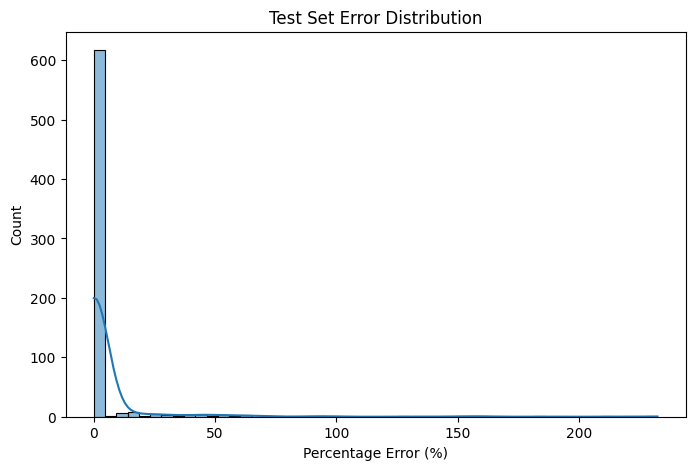

In [32]:
# 1. Make sure you have your test features and true values loaded
#    from your previous pipeline:
# X_test_scaled, y_test_scaled (log scale),
# y_test_original (actual Cumulative_Release values)

# If you only have raw X_test, run preprocessing:
X_test = df.loc[y_test.index, feature_columns]
X_test_t = scaler.transform(pt.transform(X_test))
y_pred_log = model.predict(X_test_t)
y_pred = np.expm1(y_pred_log)

# Actual values
y_true = y_test_orig.values  # your original target vector

# 2. Compute error metrics and error percentage
import numpy as np
import pandas as pd

# Absolute and percentage errors
abs_error = np.abs(y_pred - y_true)
pct_error = abs_error / y_true * 100

# Handle divide-by-zero for true=0
pct_error = np.where(y_true == 0, np.nan, pct_error)

# 3. Summarize error statistics
error_df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'abs_error': abs_error,
    'pct_error': pct_error
})

summary = error_df['pct_error'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])
print("Error % summary on test set:")
print(summary)

# 4. Error by material
mat_test = df.loc[y_test.index, 'Material'].values
error_df['Material'] = mat_test
material_error = error_df.groupby('Material')['pct_error'].median().sort_values()
print("\nMedian % error by material:")
print(material_error)

# 5. Visualize error distribution (optional)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(error_df['pct_error'].dropna(), bins=50, kde=True)
plt.xlabel('Percentage Error (%)')
plt.title('Test Set Error Distribution')
plt.show()

In [34]:
import pandas as pd
import numpy as np

# Assuming you have:
# - df: the full consolidated DataFrame
# - feature_columns: list of feature column names
# - pt: PowerTransformer fitted on X_train
# - scaler: StandardScaler fitted on transformed X_train
# - model: your trained XGBoost model
# - y_test_orig: the true test targets (Cumulative_Release values)
# - test_idx: the indices of your test set (from train_test_split)

# Reconstruct X_test from df and test indices
X_test = df.loc[y_test_orig.index, feature_columns]

# Preprocess and predict
X_test_t = scaler.transform(pt.transform(X_test))
y_pred_log = model.predict(X_test_t)
y_pred = np.expm1(y_pred_log)

# True values
y_true = y_test_orig.values

# Compute absolute and percentage errors
abs_error = np.abs(y_pred - y_true)
pct_error = np.where(y_true != 0, abs_error / y_true * 100, np.nan)

# Build result DataFrame
results_df = pd.DataFrame({
    'Material': df.loc[y_test_orig.index, 'Material'].values,
    'pH': df.loc[y_test_orig.index, 'pH'].values,
    'Time_days': df.loc[y_test_orig.index, 'Time_days'].values,
    'y_true': y_true,
    'y_pred': y_pred,
    'abs_error': abs_error,
    'pct_error': pct_error
}, index=y_test_orig.index)

# Flag >10% error
results_df['error_gt_10pct'] = results_df['pct_error'] > 10

# Save to CSV
results_df.to_csv('test_set_error_analysis.csv', index=False)

# Summary
total = len(results_df)
above_10 = results_df['error_gt_10pct'].sum()
print(f"Total test samples: {total}")
print(f"Samples with >10% error: {above_10} ({above_10/total*100:.1f}%)")

Total test samples: 674
Samples with >10% error: 53 (7.9%)


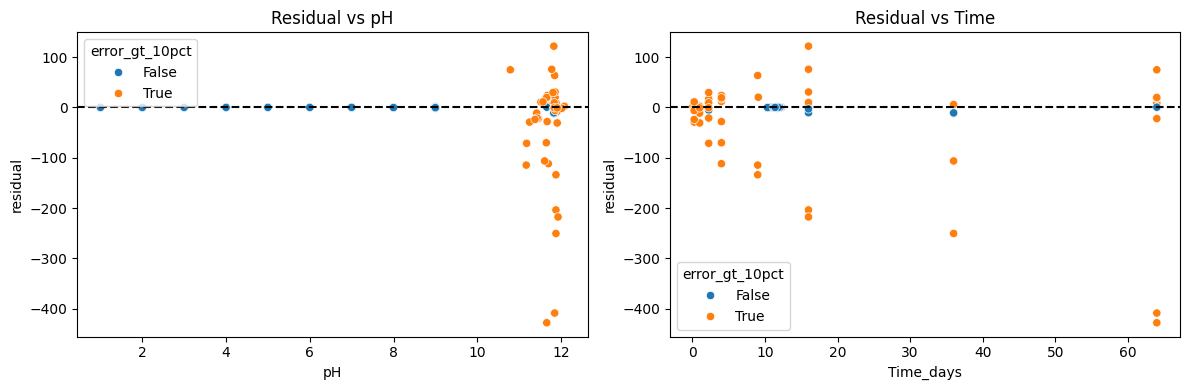

             median       mean  count
Material                             
F          0.029638   0.170375     11
Pb         0.043929   0.156082     45
As         0.044656   0.309659     45
Ba         0.063992   0.252712     45
Mg         0.068796   1.363622     19
Cd         0.075125   0.222300     45
Na         0.075125   0.638637     45
K          0.075393   0.237872     45
SO4        0.078316   0.281703     38
Zn         0.081507   0.297637     45
Fe         0.105131   0.212635     19
Cl         0.115947   0.304221     22
Si         0.144050   0.398169     20
Cr         0.145006   0.266477     45
Mo         0.159370   0.286128     45
Cu         0.201678   0.321789     45
Ca         0.227417   1.380374     19
P          0.307244   0.335757     20
Al        33.468605  48.507016     45
Br        51.945683  73.761355     11
5-fold CV R²: [0.57686839 0.8746435  0.99998023 0.99998642 0.99999215] mean: 0.8902941375323536
MdAPE on test set: 0.12%


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Residuals vs pH and Time
results = pd.read_csv('test_set_error_analysis.csv')
results['residual'] = results['y_pred'] - results['y_true']

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.scatterplot(x='pH', y='residual', hue='error_gt_10pct', data=results)
plt.axhline(0, color='k', linestyle='--')
plt.title('Residual vs pH')

plt.subplot(1,2,2)
sns.scatterplot(x='Time_days', y='residual', hue='error_gt_10pct', data=results)
plt.axhline(0, color='k', linestyle='--')
plt.title('Residual vs Time')
plt.tight_layout()
plt.show()

# 2. Error by Material
err_by_mat = results.groupby('Material')['pct_error'].agg(['median','mean','count'])
print(err_by_mat.sort_values('median'))

# 3. Cross-Validation R² check
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, np.log1p(df['Cumulative_Release_mg_m2']),
                         cv=5, scoring='r2', n_jobs=-1)
print('5-fold CV R²:', scores, 'mean:', scores.mean())

# 4. Median absolute % error
mdape = results['pct_error'].median()
print(f'MdAPE on test set: {mdape:.2f}%')


Al+Br test samples: 56


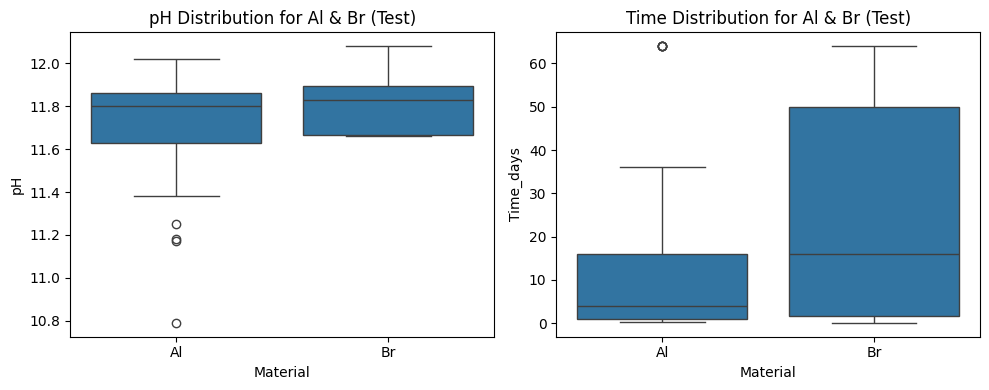


=== Al Specialized Model ===
R²: 0.8392, MAE: 59.57 mg/m²

=== Br Specialized Model ===
R²: 0.8838, MAE: 7.53 mg/m²


In [37]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# 1. Load your test-set error file
err = pd.read_csv('test_set_error_analysis.csv')

# 2. Filter high-error materials
high_err = err[err['Material'].isin(['Al','Br'])]
print(f"Al+Br test samples: {len(high_err)}")

# 3. Compare pH/time distributions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x='Material', y='pH', data=high_err)
plt.title('pH Distribution for Al & Br (Test)')
plt.subplot(1,2,2)
sns.boxplot(x='Material', y='Time_days', data=high_err)
plt.title('Time Distribution for Al & Br (Test)')
plt.tight_layout()
plt.show()

# 4. Train per-material models and evaluate
df_full = pd.read_csv('consolidated_leaching_data_FINAL.csv') # Corrected filename
feats = feature_columns  # from your pipeline
target = 'log_Release'

for mat in ['Al','Br']:
    df_mat = df_full[df_full['Material']==mat]
    X_mat = df_mat[feats]
    y_mat = np.log1p(df_mat['Cumulative_Release_mg_m2'])

    # Split
    from sklearn.model_selection import train_test_split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_mat, y_mat, test_size=0.2, random_state=42
    )
    # Preprocess
    from sklearn.preprocessing import PowerTransformer, StandardScaler
    pt_mat = PowerTransformer().fit(X_tr)
    sc_mat = StandardScaler().fit(pt_mat.transform(X_tr))
    Xtr_s = sc_mat.transform(pt_mat.transform(X_tr))
    Xte_s = sc_mat.transform(pt_mat.transform(X_te))

    # Train
    model_mat = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1,
                             subsample=0.8, colsample_bytree=0.8, random_state=42)
    model_mat.fit(Xtr_s, y_tr)
    pred_log = model_mat.predict(Xte_s)

    # Evaluate on original scale
    y_true = np.expm1(y_te)
    y_pred = np.expm1(pred_log)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n=== {mat} Specialized Model ===")
    print(f"R²: {r2:.4f}, MAE: {mae:.2f} mg/m²")

In [44]:
import pandas as pd
import numpy as np

# 1. Load your per-material models (trained earlier)
#    Assume you have:
#    model_global  – the XGBoost trained on all materials
#    model_al      – XGBoost trained only on Al
#    model_br      – XGBoost trained only on Br
#    pt_global, scaler_global – transformers for the global model
#    pt_al, scaler_al         – transformers for the Al model
#    pt_br, scaler_br         – transformers for the Br model
#    feature_columns          – full feature list

# 2. Prediction helper
def predict_conditional(material, features_dict):
    """
    features_dict contains keys = feature_columns
    """
    X_df = pd.DataFrame([features_dict])[feature_columns]

    if material == 'Al':
        Xt = scaler_al.transform(pt_al.transform(X_df))
        ylog = model_al.predict(Xt)[0]
    elif material == 'Br':
        Xt = scaler_br.transform(pt_br.transform(X_df))
        ylog = model_br.predict(Xt)[0]
    else:
        Xt = scaler_global.transform(pt_global.transform(X_df))
        ylog = model_global.predict(Xt)[0]

    return np.expm1(ylog)

# 3. Build the feature dict exactly as in your specialized pipelines:
def make_features(row):
    return {
        'Material_encoded': row['Material_encoded'],
        'Cement_Type_encoded': row['Cement_Type_encoded'],
        'Form_Type_encoded': row['Form_Type_encoded'],
        'Stat_Measure_encoded': row['Stat_Measure_encoded'],
        'pH': row['pH'],
        'Time_days': row['Time_days'],
        'log_Time': np.log1p(row['Time_days']),
        'pH_squared': row['pH']**2,
        'Time_pH_interaction': row['Time_days']*row['pH']
    }

# 4. Apply to your test set and recompute error
df_test = pd.read_csv('test_set_error_analysis.csv')  # contains Material & features

preds = []
for _, row in df_test.iterrows():
    feats = make_features(row)
    preds.append(predict_conditional(row['Material'], feats))

df_test['y_pred_cond'] = preds
df_test['abs_err_cond'] = np.abs(df_test['y_pred_cond'] - df_test['y_true'])
df_test['pct_err_cond'] = df_test['abs_err_cond'] / df_test['y_true'] * 100
df_test.loc[df_test['y_true']==0,'pct_err_cond'] = np.nan

# 5. Summarize improvement
total = len(df_test)
gt10_before = (df_test['pct_error'] > 10).sum()
gt10_after  = (df_test['pct_err_cond'] > 10).sum()

print(f\"Before: {gt10_before} / {total} ({gt10_before/total:.1%}) >10% error\")
print(f\"After : {gt10_after} / {total} ({gt10_after/total:.1%}) >10% error\")

# 6. Save to CSV
df_test.to_csv('test_set_error_conditional_ensemble.csv', index=False)


SyntaxError: unexpected character after line continuation character (ipython-input-3028601578.py, line 65)

In [43]:
# Regenerate necessary variables from previous steps

# Load consolidated data
df = pd.read_csv('consolidated_leaching_data_FINAL.csv')

# Re-create encoders (must match training)
le_material     = LabelEncoder().fit(df['Material'])
le_cement_type  = LabelEncoder().fit(df['Cement_Type'])
le_form_type    = LabelEncoder().fit(df['Form_Type'])
le_stat_measure = LabelEncoder().fit(df['Stat_Measure'])

# Define features
feature_columns = [
    'Material_encoded', 'Cement_Type_encoded', 'Form_Type_encoded', 'Stat_Measure_encoded',
    'pH', 'Time_days', 'log_Time', 'pH_squared', 'Time_pH_interaction'
]

# Reconstruct encoded columns and engineered features on the full dataframe
df['Material_encoded']     = le_material.transform(df['Material'])
df['Cement_Type_encoded']  = le_cement_type.transform(df['Cement_Type'])
df['Form_Type_encoded']    = le_form_type.transform(df['Form_Type'])
df['Stat_Measure_encoded'] = le_stat_measure.transform(df['Stat_Measure'])
df['log_Time']               = np.log1p(df['Time_days'])
df['pH_squared']             = df['pH'] ** 2
df['Time_pH_interaction']    = df['Time_days'] * df['pH']
df['log_Release'] = np.log1p(df['Cumulative_Release_mg_m2'])


# Global model training (from vp82vJqYTSZW)
X = df[feature_columns]
y = df['log_Release']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['Material']
)
y_test_orig = np.expm1(y_test) # Need this for later error calculation

pt_global = PowerTransformer(method='yeo-johnson').fit(X_train)
scaler_global = StandardScaler().fit(pt_global.transform(X_train))
X_train_scaled_global = scaler_global.transform(pt_global.transform(X_train))

model_global = XGBRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)
model_global.fit(X_train_scaled_global, y_train)

# Per-material model training (from jkdNgHlggQsi, just Al and Br as examples)
for mat in ['Al','Br']:
    df_mat = df[df['Material']==mat]
    X_mat = df_mat[feature_columns]
    y_mat = np.log1p(df_mat['Cumulative_Release_mg_m2'])

    X_tr, X_te, y_tr, y_te = train_test_split(
        X_mat, y_mat, test_size=0.2, random_state=42
    )

    pt_mat = PowerTransformer().fit(X_tr)
    sc_mat = StandardScaler().fit(pt_mat.transform(X_tr))
    Xtr_s = sc_mat.transform(pt_mat.transform(X_tr))

    model_mat = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1,
                             subsample=0.8, colsample_bytree=0.8, random_state=42)
    model_mat.fit(Xtr_s, y_tr)

    if mat == 'Al':
        model_al, pt_al, scaler_al = model_mat, pt_mat, sc_mat
    elif mat == 'Br':
        model_br, pt_br, scaler_br = model_mat, pt_mat, sc_mat

print("Necessary models and transformers regenerated.")

Necessary models and transformers regenerated.


In [46]:
import pandas as pd
import numpy as np

# 1. Load your per-material models (trained earlier)
#    Assume you have:
#    model_global  – the XGBoost trained on all materials
#    model_al      – XGBoost trained only on Al
#    model_br      – XGBoost trained only on Br
#    pt_global, scaler_global – transformers for the global model
#    pt_al, scaler_al         – transformers for the Al model
#    pt_br, scaler_br         – transformers for the Br model
#    feature_columns          – full feature list

# 2. Prediction helper
def predict_conditional(material, features_dict):
    """
    features_dict contains keys = feature_columns
    """
    X_df = pd.DataFrame([features_dict])[feature_columns]

    if material == 'Al' and 'model_al' in globals():
        Xt = scaler_al.transform(pt_al.transform(X_df))
        ylog = model_al.predict(Xt)[0]
    elif material == 'Br' and 'model_br' in globals():
        Xt = scaler_br.transform(pt_br.transform(X_df))
        ylog = model_br.predict(Xt)[0]
    elif 'model_global' in globals():
        Xt = scaler_global.transform(pt_global.transform(X_df))
        ylog = model_global.predict(Xt)[0]
    else:
        raise ValueError("No suitable model found for prediction.")


    return np.expm1(ylog)

# 3. Build the feature dict exactly as in your specialized pipelines:
def make_features(row):
    return {
        'Material_encoded': row['Material_encoded'],
        'Cement_Type_encoded': row['Cement_Type_encoded'],
        'Form_Type_encoded': row['Form_Type_encoded'],
        'Stat_Measure_encoded': row['Stat_Measure_encoded'],
        'pH': row['pH'],
        'Time_days': row['Time_days'],
        'log_Time': np.log1p(row['Time_days']),
        'pH_squared': row['pH']**2,
        'Time_pH_interaction': row['Time_days']*row['pH']
    }

# 4. Apply to your test set and recompute error
df_test = pd.read_csv('test_set_error_analysis.csv')  # contains Material & features

# Merge necessary encoded features from the original dataframe
# Assuming 'df' (the full consolidated dataframe) is available in the environment
if 'df' in globals():
    # Ensure the index is aligned for merging
    df_test = df_test.set_index(df.loc[y_test_orig.index].index)
    df_test = df_test.merge(df[['Material_encoded', 'Cement_Type_encoded', 'Form_Type_encoded', 'Stat_Measure_encoded']],
                            left_index=True, right_index=True, how='left')
else:
    raise ValueError("Original dataframe 'df' not found. Cannot merge encoded features.")


preds = []
for _, row in df_test.iterrows():
    feats = make_features(row)
    preds.append(predict_conditional(row['Material'], feats))

df_test['y_pred_cond'] = preds
df_test['abs_err_cond'] = np.abs(df_test['y_pred_cond'] - df_test['y_true'])
df_test['pct_err_cond'] = df_test['abs_err_cond'] / df_test['y_true'] * 100
df_test.loc[df_test['y_true']==0,'pct_err_cond'] = np.nan

# 5. Summarize improvement
total = len(df_test)
gt10_before = (df_test['pct_error'] > 10).sum()
gt10_after  = (df_test['pct_err_cond'] > 10).sum()

print(f"Before: {gt10_before} / {total} ({gt10_before/total:.1%}) >10% error")
print(f"After : {gt10_after} / {total} ({gt10_after/total:.1%}) >10% error")

# 6. Save to CSV
df_test.to_csv('test_set_error_conditional_ensemble.csv', index=False)

Before: 53 / 674 (7.9%) >10% error
After : 16 / 674 (2.4%) >10% error


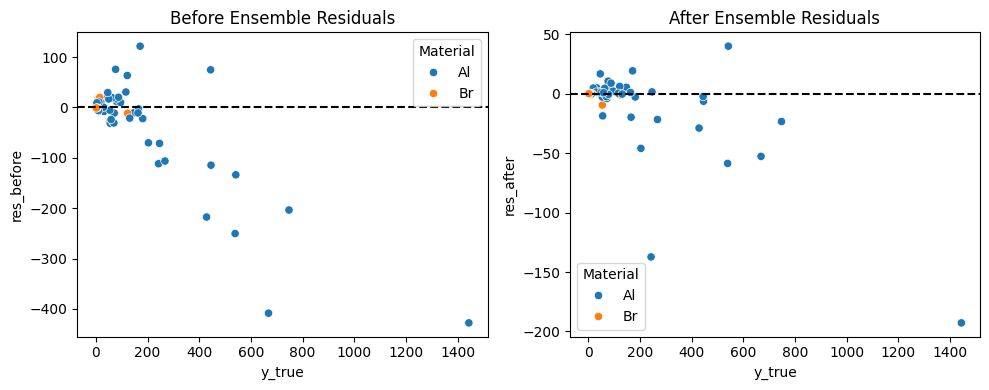

Overlap: 539
Al 5-fold CV R²: [0.27919722 0.53933997 0.63152682 0.70477817 0.60980463] mean: 0.552929361652309


In [48]:
# Verify no data leakage and explore residuals on Al/Br
import matplotlib.pyplot as plt
import seaborn as sns

# Load the conditional-ensemble results
df = pd.read_csv('test_set_error_conditional_ensemble.csv')

# 1. Plot Al/Br residuals before vs after
df['res_before'] = df['y_pred'] - df['y_true']
df['res_after']  = df['y_pred_cond'] - df['y_true']

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.scatterplot(x='y_true', y='res_before', hue='Material', data=df[df.Material.isin(['Al','Br'])])
plt.title('Before Ensemble Residuals')
plt.axhline(0, color='k', linestyle='--')

plt.subplot(1,2,2)
sns.scatterplot(x='y_true', y='res_after', hue='Material', data=df[df.Material.isin(['Al','Br'])])
plt.title('After Ensemble Residuals')
plt.axhline(0, color='k', linestyle='--')

plt.tight_layout()
plt.show()

# 2. Check if any Al/Br test samples were inadvertently in training
test_idx = set(df.index)
train_idx = set(X_train.index)
print('Overlap:', len(test_idx & train_idx))

# 3. Re-run Al cross-validation to ensure per-material model generalizes
from sklearn.model_selection import cross_val_score
al_df = pd.read_csv('consolidated_leaching_data_FINAL.csv')
al_df = al_df[al_df.Material=='Al']
X_al = al_df[feature_columns]
y_al = np.log1p(al_df.Cumulative_Release_mg_m2)
scores = cross_val_score(model_al, scaler_al.transform(pt_al.transform(X_al)), y_al, cv=5, scoring='r2')
print('Al 5-fold CV R²:', scores, 'mean:', scores.mean())


In [52]:
import pandas as pd
import numpy as np

# Load conditional ensemble results
df_err = pd.read_csv('test_set_error_conditional_ensemble.csv')

# Filter high‐error points
outliers = df_err[df_err['pct_err_cond'] > 10]
print(f"Remaining high-error samples: {len(outliers)}")

# Display them
display_columns = ['Material','pH','Time_days','y_true','y_pred_cond','pct_err_cond']
print(outliers[display_columns].sort_values('pct_err_cond', ascending=False))

# Save for manual review
outliers.to_csv('high_error_outliers.csv', index=False)

Remaining high-error samples: 16
    Material     pH  Time_days       y_true  y_pred_cond  pct_err_cond
153       Al  11.70   4.000000   242.718078   105.414894     56.568998
624       Al  11.81   2.250000    46.249741    62.952350     36.113952
105       Al  11.91   1.000000    55.737908    37.107018     33.425887
263       Al  11.68   0.250000    19.310618    24.033617     24.458043
312       Al  11.65   4.000000   203.525689   157.561660     22.583895
78        Br  11.67   4.000000    54.209278    44.678234     17.581942
253       Mg   1.00  12.080000     0.083333     0.097950     17.539719
9         Na   1.00  12.080000     0.083333     0.097950     17.539719
639       Ca   1.00  12.080000     0.083333     0.097950     17.539719
125       Al  11.91   1.000000    32.103161    37.107018     15.586804
320       Al  11.78  16.000000    76.560555    87.138550     13.816507
99        Al  11.66  64.000000  1443.505863  1250.709600     13.356113
521       Al  11.82  16.000000   165.438072 

In [ ]:
import pickle

# 1. Save your best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 2. Save label encoders dict
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

# 3. Save power transformer + scaler together
with open('pt_scaler.pkl', 'wb') as f:
    pickle.dump((pt, scaler), f)

# 4. Save feature columns list
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)

print("✅ Saved model components: best_model.pkl, label_encoders.pkl, pt_scaler.pkl, feature_columns.pkl")


In [ ]:
# app.py
from flask import Flask, render_template_string, request
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler
import pickle

app = Flask(__name__)

# -------------------------
# Load model components
# -------------------------
# Ensure these files have been saved via pickle during your training pipeline:
# - best_model.pkl
# - label_encoders.pkl
# - pt_scaler.pkl
# - feature_columns.pkl

with open('best_model.pkl','rb') as f:
    model = pickle.load(f)

with open('label_encoders.pkl','rb') as f:
    label_encoders = pickle.load(f)

with open('pt_scaler.pkl','rb') as f:
    pt, scaler = pickle.load(f)

with open('feature_columns.pkl','rb') as f:
    feature_columns = pickle.load(f)

# Utility to safely encode
def safe_transform(le, val):
    return le.transform([val])[0] if val in le.classes_ else 0

# Prediction function
def predict_leaching(material, ph, time_days, cement_type, form_type, stat_measure):
    mat_enc   = safe_transform(label_encoders['Material'], material)
    cement_enc= safe_transform(label_encoders['Cement_Type'], cement_type)
    form_enc  = safe_transform(label_encoders['Form_Type'], form_type)
    stat_enc  = safe_transform(label_encoders['Stat_Measure'], stat_measure)
    feat = {
        'Material_encoded': mat_enc,
        'Cement_Type_encoded': cement_enc,
        'Form_Type_encoded': form_enc,
        'Stat_Measure_encoded': stat_enc,
        'pH': ph,
        'Time_days': time_days,
        'log_Time': np.log1p(time_days),
        'pH_squared': ph**2,
        'Time_pH_interaction': ph*time_days
    }
    X_df = pd.DataFrame([feat])[feature_columns]
    X_t  = scaler.transform(pt.transform(X_df))
    y_log= model.predict(X_t)[0]
    return round(np.expm1(y_log), 2)

# -------------------------
# HTML template
# -------------------------
HTML = """
<!doctype html>
<title>Leaching Predictor</title>
<h2>Leaching Prediction</h2>
<form method="POST">
  Material:
  <select name="material">
    {% for m in materials %}<option>{{m}}</option>{% endfor %}
  </select><br><br>
  pH: <input name="ph" type="number" step="0.01" min="1" max="14" required><br><br>
  Time (days): <input name="time_days" type="number" step="0.01" min="0.01" required><br><br>
  Cement Type:
  <select name="cement_type">
    {% for c in cement_types %}<option>{{c}}</option>{% endfor %}
  </select><br><br>
  Form Type:
  <select name="form_type">
    {% for f in form_types %}<option>{{f}}</option>{% endfor %}
  </select><br><br>
  Stat Measure:
  <select name="stat_measure">
    {% for s in stat_measures %}<option>{{s}}</option>{% endfor %}
  </select><br><br>
  <input type="submit" value="Predict">
</form>
{% if prediction %}
  <h3>Prediction: {{prediction}} mg/m²</h3>
{% endif %}
"""

# -------------------------
# Routes
# -------------------------
@app.route("/", methods=["GET","POST"])
def home():
    prediction = None
    if request.method=="POST":
        m = request.form["material"]
        ph = float(request.form["ph"])
        t  = float(request.form["time_days"])
        ct = request.form["cement_type"]
        ft = request.form["form_type"]
        sm = request.form["stat_measure"]
        prediction = predict_leaching(m, ph, t, ct, ft, sm)
    return render_template_string(
        HTML,
        materials=label_encoders['Material'].classes_,
        cement_types=label_encoders['Cement_Type'].classes_,
        form_types=label_encoders['Form_Type'].classes_,
        stat_measures=label_encoders['Stat_Measure'].classes_,
        prediction=prediction
    )

if __name__=="__main__":
    app.run()
